In [2]:
import pygris
from epymorph.data import geo_library, ipm_library, mm_library
import numpy as np
from numpy.typing import DTypeLike, NDArray
import math
from sympy import centroid 
from epymorph.geo.geo import Geo
from typing import (List, TypeVar)
N = TypeVar('N', bound=np.number)
import geopandas as gpd
from shapely.geometry import Polygon, mapping
import pandas as pd
import epymorph.util
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.initializer import bird_movement_initializer, single_location
from epymorph.simulation import Simulation, configure_sim_logging
from datetime import date
import matplotlib.pyplot as plt
from epymorph.run import plot_event, plot_pop
from importlib import reload
import logging

In [35]:
from epymorph.initializer import initialize

geo=geo_library['maricopa_cbg_2019']()
print(geo.values)
epymorph_geo_id = geo.values['geoid']
geo.values['bird_population'] = geo.values['population']
source_node = '040130927211'
def find_source_node_index(source_node:str):
    for i in range(0,len(epymorph_geo_id)):
     if(epymorph_geo_id[i] == source_node):
        target_index = i
        return target_index
target_index = find_source_node_index(source_node)   
geo.values['bird_population'][target_index] = 5000
print(geo.values)




    


{'average_household_size': array([2.33, 2.15, 1.83, ..., 1.87, 4.29, 3.33]), 'centroid': array([(-111.77075643, 33.76924661), (-111.72000671, 33.74109333),
       (-111.6669757 , 33.72404114), ..., (-111.88183665, 33.45074909),
       (-111.84018578, 33.49859254), (-111.61909768, 33.33555257)],
      dtype=[('longitude', '<f8'), ('latitude', '<f8')]), 'geoid': array(['040130101011', '040130101012', '040130101013', ...,
       '040139413003', '040139413004', '040139806001'], dtype='<U12'), 'label': array(['040130101011', '040130101012', '040130101013', ...,
       '040139413003', '040139413004', '040139806001'], dtype='<U12'), 'median_age': array([50.5, 63.9, 70.8, ..., 64.8, 26.7, 34.1]), 'median_income': array([ 99219, 127614,  80742, ...,  33720,  36384, 136875], dtype=int64), 'pop_density_km2': array([ 99.31999906,  68.78239768, 183.89086892, ..., 169.20688695,
       110.89816933, 432.8874186 ]), 'population': array([1791, 2007, 1264, ..., 1865, 3049, 4291], dtype=int64), 'populati

In [36]:
sim = Simulation(geo=geo, ipm_builder=ipm_library['no'](), mvm_builder=mm_library['local_birds']())
out = sim.run({
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
        'humidity' : 0.4,
        "seed_size" : 100,
        "beta" : 0.4,
        "gamma" : 0.25,
        'xi': 0.0111, # 1/90
        'phi': 40.0,
        'location':5,
        'theta': 0.1,
        'move_control': 0.9,
       },start_date=date(2023,1,1),duration_days=10, initializer=bird_movement_initializer)


In [37]:
import pandas as pd
pd.options.display.max_seq_items = 2000
state="Arizona"
pygris_county = pygris.block_groups(state,county="Maricopa",year=2019)
epymorph_geo_id = out.ctx.geo['geoid']
movement_numbers_time_index_0 =  out.prevalence[0]
for i in out.prevalence:
  print(i)
print("Movement Numbers : ",movement_numbers_time_index_0)


Using FIPS code '04' for input 'Arizona'
Using FIPS code '013' for input 'Maricopa'
[[1686]
 [1902]
 [1208]
 ...
 [1880]
 [2810]
 [9468]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1671]
 [1876]
 [1221]
 ...
 [1877]
 [2807]
 [9546]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1697]
 [1906]
 [1194]
 ...
 [1862]
 [2813]
 [9481]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1684]
 [1889]
 [1194]
 ...
 [1888]
 [2800]
 [9456]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1687]
 [1899]
 [1207]
 ...
 [1849]
 [2816]
 [9544]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1685]
 [1883]
 [1219]
 ...
 [1859]
 [2808]
 [9482]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1684]
 [1880]
 [1191]
 ...
 [1878]
 [2822]
 [9525]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1688]
 [1881]
 [1190]
 ...
 [1871]
 [2799]
 [9553]]
[[1791]
 [2007]
 [1264]
 ...
 [1865]
 [3049]
 [4291]]
[[1687]
 [1898]
 [1204]
 ...
 [1878]
 [2822]
 [9544]

In [38]:
import itertools
dfs=[]
for i in range(0,len(movement_numbers_time_index_0)):
    probabilities = movement_numbers_time_index_0
    source_node = epymorph_geo_id[i]
    data = {'Source Node': source_node,
            'Destination Node': epymorph_geo_id,
            'Probability': probabilities.flatten()}
    df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
    df['Source Node']=df['Source Node'].fillna(source_node)
    dfs.append(df)
result_df = pd.concat(dfs,ignore_index=True)
print(result_df)
    


          Source Node Destination Node  Probability
0        040130101011     040130101011         1686
1        040130101011     040130101012         1902
2        040130101011     040130101013         1208
3        040130101011     040130101021         1026
4        040130101011     040130101022         1390
...               ...              ...          ...
6220031  040139806001     040139413001         1905
6220032  040139806001     040139413002          784
6220033  040139806001     040139413003         1880
6220034  040139806001     040139413004         2810
6220035  040139806001     040139806001         9468

[6220036 rows x 3 columns]


In [39]:
geo_id_geometry_dict={}
for index,each_county in pygris_county.iterrows():
   geo_id_geometry_dict[each_county["GEOID"]] = each_county["geometry"]
geometry=[Polygon(cords) for cords in geo_id_geometry_dict.values()]
gdf = gpd.GeoDataFrame(data={'GEOID': geo_id_geometry_dict.keys()},geometry=geometry,index=None)
print(gdf)

             GEOID                                           geometry
0     040134217023  POLYGON ((-111.78406 33.41540, -111.78259 33.4...
1     040130405312  POLYGON ((-112.37679 33.64389, -112.37673 33.6...
2     040130923121  POLYGON ((-112.20294 33.56672, -112.20293 33.5...
3     040130927211  POLYGON ((-112.25507 33.53763, -112.25507 33.5...
4     040130931041  POLYGON ((-112.18194 33.50955, -112.18193 33.5...
...            ...                                                ...
2500  040138119002  POLYGON ((-111.87111 33.28352, -111.87031 33.2...
2501  040138120001  POLYGON ((-111.85867 33.28374, -111.85848 33.2...
2502  040138120002  POLYGON ((-111.85885 33.29153, -111.85853 33.2...
2503  040135230023  POLYGON ((-111.85910 33.30737, -111.85908 33.3...
2504  040135231023  POLYGON ((-111.83702 33.29890, -111.83656 33.2...

[2505 rows x 2 columns]


C:\Users\sp2665\AppData\Local\Temp\ipykernel_3200\4112401611.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Add legend for the source node
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


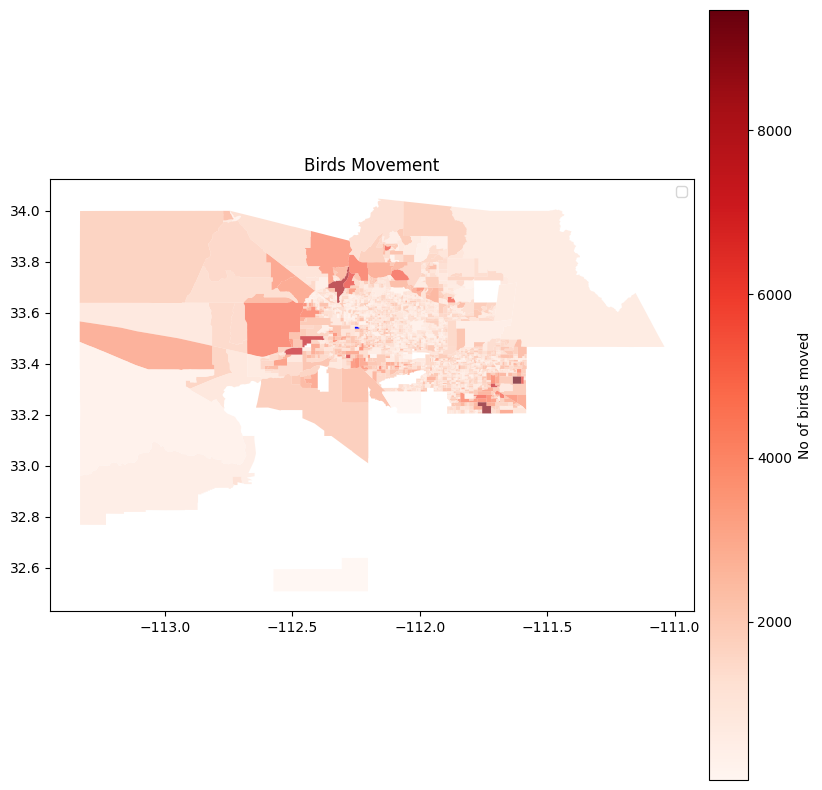

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from epymorph.ipm.compartment_model import edge
def plotMaricopaMovementProbability(result,source_node: str):
    source_data = result[result['Destination Node'] == source_node]
    norm = Normalize(vmin=result['Probability'].min(), vmax=result['Probability'].max())
    sm = ScalarMappable(cmap='Reds', norm=norm)
    # Plot the base map for destination nodes
    fig, ax = plt.subplots(figsize=(10, 10))
    destination_data = result[result['Destination Node'] != source_node]
    destination_data.plot(ax=ax, color=sm.to_rgba(destination_data['Probability']), alpha=0.7)

    # Plot the source node with a different color (blue)
    source_data.plot(ax=ax,color='blue',markersize=50, label='Source Node')
    # Add colorbar with red shades
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('No of birds moved')
    # Set title and show the plot
    plt.title('Birds Movement')
    plt.legend()  # Add legend for the source node
    plt.show()

dataframe = gdf.merge(result_df, left_on = 'GEOID' ,right_on = 'Destination Node' ,how='inner')
source_node = '040130927211'
result = dataframe[dataframe['Source Node']== source_node]
plotMaricopaMovementProbability(result,source_node)
